In [1]:
from __future__ import print_function, division
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

# Initial Model

In [2]:
# load model parameters
from galaxy_shapes.model_fitting.fit_1.sample_1_fitting_params import params as params_1
from galaxy_shapes.model_fitting.fit_1.sample_2_fitting_params import params as params_2
from galaxy_shapes.model_fitting.fit_1.sample_3_fitting_params import params as params_3
from galaxy_shapes.model_fitting.fit_1.sample_4_fitting_params import params as params_4
from galaxy_shapes.model_fitting.fit_1.sample_5_fitting_params import params as params_5
from galaxy_shapes.model_fitting.fit_1.sample_6_fitting_params import params as params_6
params = [params_1,params_2,params_3,params_4,params_5,params_6]

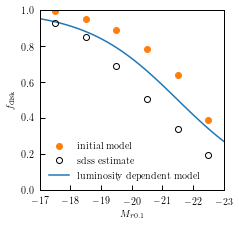

In [5]:
# model for fraction of disk and elliptical galaxies
from galaxy_shapes.shape_models.morphology_model_components import Morphology_2
morpholopgy_model = Morphology_2()

from astropy.table import Table
comparison_fpath = '../../../sdss_measurements/data/'
t0 = Table.read(comparison_fpath + 'disk_fraction.dat', format='ascii')

x = np.linspace(-16,-24,100)

f_disk = [params[0]['theta0'][8],params[1]['theta0'][8],
          params[2]['theta0'][8],params[3]['theta0'][8],
          params[4]['theta0'][8],params[5]['theta0'][8]]

plt.figure(figsize=(3.3,3.3))
p1, = plt.plot(x, morpholopgy_model.disk_fraction(x))
p2, = plt.plot(t0['mag'], f_disk, 'o')
p3, = plt.plot(t0['mag'], t0['f_disk'],
               'o', color='black', markerfacecolor="None")
plt.ylim([0,1])
plt.xlim([-17,-23])
plt.ylabel(r'$f_{\rm disk}$')
plt.xlabel(r'$M_{r0.1}$')
plt.legend([p2,p3,p1],['initial model','sdss estimate','luminosity dependent model'],
           frameon=False, loc='lower left')
plt.show()

## Compare to Observations

In [6]:
from galaxy_shapes.model_fitting.fit_1.make_mock import make_galaxy_sample

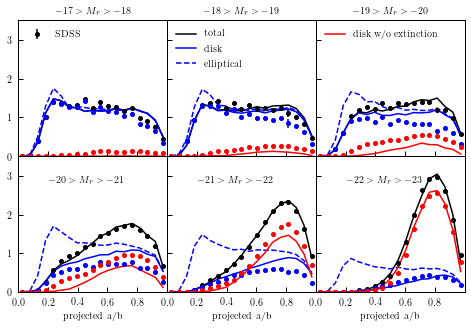

In [9]:
comparison_fpath = '../../../sdss_measurements/data/'

fig, axes = plt.subplots(2, 3, figsize=(8.0,5.0), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)
axes = axes.flatten()
    
mag_lims = np.array([-17,-18,-19,-20,-21,-22])
samples = ['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6']

for i in range(0,6):
    
    # set axis
    ax = axes[i]
    ax.set_ylim([0,3.5])
    
    # load comparison sample
    sample = samples[i]
    
    # plot observational data
    t = Table.read(comparison_fpath+sample+'_all_DEV_shapes.dat', format='ascii')
    p1 = ax.errorbar(t['q'], t['frequency'], t['err'], fmt='o', ms=4, color='black')
    
    t = Table.read(comparison_fpath+sample+'_disks_DEV_shapes.dat', format='ascii')
    p2 = ax.errorbar(t['q'], t['frequency']*t0['f_disk'][i], t['err']*t0['f_disk'][i], fmt='o', ms=4, color='blue')
    
    t = Table.read(comparison_fpath+sample+'_ellipticals_DEV_shapes.dat', format='ascii')
    p3 = ax.errorbar(t['q'], t['frequency']*(1-t0['f_disk'][i]), t['err']*(1-t0['f_disk'][i]), fmt='o', ms=4, color='red')
    
    # make mock
    theta = params[i]['theta0']
    
    gal_type = '_centrals' # hack to use halotools structure
    d = {'disk_shape_mu_1'+gal_type: theta[0],
         'disk_shape_mu_2'+gal_type: theta[1],
         'disk_shape_sigma_1'+gal_type: theta[2],
         'disk_shape_sigma_2'+gal_type: theta[3],
         'elliptical_shape_mu_1'+gal_type: theta[4],
         'elliptical_shape_mu_2'+gal_type: theta[5],
         'elliptical_shape_sigma_1'+gal_type: theta[6],
         'elliptical_shape_sigma_2'+gal_type: theta[7],
         'f_disk':theta[8]}
    
    mag_lim = params[i]['mag_lim']
    
    # populate mock
    mock = make_galaxy_sample(mag_lim=mag_lim[0], **d)
    
    disks = mock['disk']==True
    ellipticals = mock['elliptical']==True
    
    # create mask for galaxy sample
    mag_key = 'obs_Mag_r'
    mask = (mock[mag_key]<mag_lim[0]) & (mock[mag_key]>(mag_lim[1]))
    mag_key = 'Mag_r'
    mask_0 = (mock[mag_key]<mag_lim[0]) & (mock[mag_key]>(mag_lim[1]))
    
    # mock galaxy shape parameter
    x = mock['galaxy_projected_b_to_a']
    w = mock['weight']

    # measure shape distribution
    bins = np.linspace(0,1,20)
    bin_centers = (bins[:-1]+bins[1:])/2.0
    
    # plot total distribution
    counts = np.histogram(x[mask], bins=bins, weights=w[mask])[0]
    n_1 = np.sum(counts)
    counts = 1.0*counts/n_1/np.diff(bins)
    l1, = ax.plot(bin_centers, counts, color='black')
    
    counts = np.histogram(x[mask & disks], bins=bins, weights=w[mask & disks])[0]
    n_2 = np.sum(counts)
    counts = 1.0*counts/n_1/np.diff(bins)
    l2, = ax.plot(bin_centers, counts, color='blue')
    
    counts = np.histogram(x[mask_0 & disks], bins=bins, weights=w[mask_0 & disks])[0]
    n_2 = np.sum(counts)
    counts = 1.0*counts/n_1/np.diff(bins)
    l3, = ax.plot(bin_centers, counts, '--', color='blue')
    
    counts = np.histogram(x[mask & ellipticals], bins=bins, weights=w[mask & ellipticals])[0]
    n_3 = np.sum(counts)
    counts = 1.0*counts/n_1/np.diff(bins)
    l4, = ax.plot(bin_centers, counts, color='red')

axes[0].set_title(r'$-17>M_r>-18$')
axes[1].set_title(r'$-18>M_r>-19$')
axes[2].set_title(r'$-19>M_r>-20$')
axes[3].text(0.2, 2.8, r'$-20>M_r>-21$')
axes[3].set_xlabel('projected a/b')
axes[4].text(0.2, 2.8, r'$-21>M_r>-22$')
axes[4].set_xlabel('projected a/b')
axes[5].text(0.2, 2.8, r'$-22>M_r>-23$')
axes[5].set_xlabel('projected a/b')
axes[5].set_xticks([0,0.2,0.4,0.6,0.8])
axes[5].set_xlim([0,1])

axes[0].legend([p1],['SDSS'],
               frameon=False, loc='upper left')
axes[1].legend([l1,l2,l3],['total','disk', 'elliptical'],
               frameon=False, loc='upper left')
axes[2].legend([l4],['disk w/o extinction'],
               frameon=False, loc='upper left')

plt.show()